# <b><span style='color:#F1A424'>|</span> Import Libraries</b><a class='anchor' id='import_libraries'></a> [↑](#top)

---

Import all the required libraries for this notebook.


In [8]:
import albumentations as A
import gc
import librosa
import matplotlib.pyplot as plt
import math
import multiprocessing
import numpy as np
import os
import pandas as pd
import pywt
import random
import time
import timm
import torch
import torch.nn as nn


from albumentations.pytorch import ToTensorV2
from glob import glob
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from typing import Dict, List
import librosa
from scipy.signal import butter, filtfilt, iirnotch
import json

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using", torch.cuda.device_count(), "GPU(s)")

Using 1 GPU(s)


# <b><span style='color:#F1A424'>|</span> Configuration</b><a class='anchor' id='configuration'></a> [↑](#top)

---


In [9]:
import copy


class config:
    BATCH_SIZE = 64
    MODEL = "tf_efficientnet_b0"
    LARGE_CLASSIFIER = False
    NUM_WORKERS = 0  # multiprocessing.cpu_count()
    PRINT_FREQ = 20
    SEED = 20
    VISUALIZE = False

    NORMALIZE_KAGGLE_SPECS = True
    NORMALIZE_EEG_SPECS = True
    BUTTER = True
    NOTCH = True


class EffL:
    BATCH_SIZE = 64
    MODEL = "tf_efficientnet_b0"
    LARGE_CLASSIFIER = True
    NUM_WORKERS = 0  # multiprocessing.cpu_count()
    PRINT_FREQ = 20
    SEED = 20
    VISUALIZE = False

    NORMALIZE_KAGGLE_SPECS = True
    NORMALIZE_EEG_SPECS = True
    BUTTER = True
    NOTCH = True


class resL:
    BATCH_SIZE = 64
    MODEL = "resnet50"  # "resnet50"#"tf_efficientnet_b0" "shufflenet_v2_x1_0"
    LARGE_CLASSIFIER = True
    NUM_WORKERS = 0  # multiprocessing.cpu_count()
    PRINT_FREQ = 20
    SEED = 20
    VISUALIZE = False

    NORMALIZE_KAGGLE_SPECS = True
    NORMALIZE_EEG_SPECS = True
    BUTTER = True
    NOTCH = True


class resS:
    BATCH_SIZE = 64
    MODEL = "resnet50"  # "resnet50"#"tf_efficientnet_b0" "shufflenet_v2_x1_0"
    LARGE_CLASSIFIER = False
    NUM_WORKERS = 0  # multiprocessing.cpu_count()
    PRINT_FREQ = 20
    SEED = 20
    VISUALIZE = False

    NORMALIZE_KAGGLE_SPECS = True
    NORMALIZE_EEG_SPECS = True
    BUTTER = True
    NOTCH = True


class ShuffleS:
    BATCH_SIZE = 64
    MODEL = "shufflenet_v2_x1_0"  # "resnet50"#"tf_efficientnet_b0" "shufflenet_v2_x1_0"
    LARGE_CLASSIFIER = False
    NUM_WORKERS = 0  # multiprocessing.cpu_count()
    PRINT_FREQ = 20
    SEED = 20
    VISUALIZE = False

    NORMALIZE_KAGGLE_SPECS = True
    NORMALIZE_EEG_SPECS = True
    BUTTER = True
    NOTCH = True


class ShuffleL:
    BATCH_SIZE = 64
    MODEL = "shufflenet_v2_x1_0"  # "resnet50"#"tf_efficientnet_b0" "shufflenet_v2_x1_0"
    LARGE_CLASSIFIER = True
    NUM_WORKERS = 0  # multiprocessing.cpu_count()
    PRINT_FREQ = 20
    SEED = 20
    VISUALIZE = False

    NORMALIZE_KAGGLE_SPECS = True
    NORMALIZE_EEG_SPECS = True
    BUTTER = True
    NOTCH = True


class paths:
    OUTPUT_DIR = "/kaggle/working/"
    TEST_CSV = "/kaggle/input/hms-harmful-brain-activity-classification/test.csv"
    TEST_EEGS = "/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/"
    TEST_SPECTROGRAMS = (
        "/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/"
    )
    DATA_STATS_KAGGLE = (
        "/kaggle/input/final-preprocessed-data/kaggle_specs_info_final.json"
    )
    DATA_STATS_EEG = "/kaggle/input/final-preprocessed-data/eeg_specs_info_final.json"


configs = [config]
model_weights = [
    "/kaggle/input/b0-first-run/tf_efficientnet_b0_fold_4_best_False_best_prepr.pth"
]

model_weights
model_weights = zip(configs, model_weights)
model_weights
for conf in configs:
    print(conf.MODEL)

tf_efficientnet_b0


# <b><span style='color:#F1A424'>|</span> Utils</b><a class='anchor' id='utils'></a> [↑](#top)

---

Utility functions:

- [pywt.wavedec][1]

[1]: https://pywavelets.readthedocs.io/en/latest/ref/dwt-discrete-wavelet-transform.html#multilevel-decomposition-using-wavedec


In [10]:
USE_WAVELET = None

NAMES = ["LL", "LP", "RP", "RR"]

FEATS = [
    ["Fp1", "F7", "T3", "T5", "O1"],
    ["Fp1", "F3", "C3", "P3", "O1"],
    ["Fp2", "F8", "T4", "T6", "O2"],
    ["Fp2", "F4", "C4", "P4", "O2"],
]


def maddest(d, axis: int = None):
    """
    Denoise function.
    """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)


def denoise(x: np.ndarray, wavelet: str = "haar", level: int = 1):
    coeff = pywt.wavedec(
        x, wavelet, mode="per"
    )  # multilevel 1D Discrete Wavelet Transform of data.
    sigma = (1 / 0.6745) * maddest(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode="hard") for i in coeff[1:])
    output = pywt.waverec(coeff, wavelet, mode="per")
    return output


def spectrogram_from_eeg(parquet_path, display=False):
    # Bandpass and notch filter coefficients
    order_band = 5
    low_cut_freq = 0.7
    high_cut_freq = 20
    nyquist_freq = 0.5 * 200
    low_cut_freq_normalized = low_cut_freq / nyquist_freq
    high_cut_freq_normalized = high_cut_freq / nyquist_freq
    bandpass_coefficients = butter(
        order_band, [low_cut_freq_normalized, high_cut_freq_normalized], btype="band"
    )
    notch_coefficients = iirnotch(w0=60, Q=30, fs=200)

    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg) - 10_000) // 2
    eeg = eeg.iloc[middle : middle + 10_000]

    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((128, 256, 4), dtype="float32")

    if display:
        plt.figure(figsize=(10, 7))
    signals = []
    for k in range(4):
        COLS = FEATS[k]

        for kk in range(4):

            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[kk]].values - eeg[COLS[kk + 1]].values

            # FILL NANS
            m = np.nanmean(x)
            if np.isnan(x).mean() < 1:
                x = np.nan_to_num(x, nan=m)
            else:
                x[:] = 0

            # DENOISE
            if USE_WAVELET:
                x = denoise(x, wavelet=USE_WAVELET)
            signals.append(x)

            # Notch filter and Butterworth low and high pass
            if config.NOTCH:
                x = filtfilt(*notch_coefficients, x)

            if config.BUTTER:
                x = filtfilt(*bandpass_coefficients, x)

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(
                y=x,
                sr=200,
                hop_length=len(x) // 256,
                n_fft=1024,
                n_mels=128,
                fmin=0,
                fmax=20,
                win_length=128,
            )

            # LOG TRANSFORM
            width = (mel_spec.shape[1] // 32) * 32
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[
                :, :width
            ]

            # STANDARDIZE TO -1 TO 1
            mel_spec_db = (mel_spec_db + 40) / 40
            img[:, :, k] += mel_spec_db

        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:, :, k] /= 4.0

        if display:
            plt.subplot(2, 2, k + 1)
            plt.imshow(img[:, :, k], aspect="auto", origin="lower")
            plt.title(f"EEG {eeg_id} - Spectrogram {NAMES[k]}")

    if display:
        plt.show()
        plt.figure(figsize=(10, 5))
        offset = 0
        for k in range(4):
            if k > 0:
                offset -= signals[3 - k].min()
            plt.plot(range(10_000), signals[k] + offset, label=NAMES[3 - k])
            offset += signals[3 - k].max()
        plt.legend()
        plt.title(f"EEG {eeg_id} Signals")
        plt.show()
        print()
        print("#" * 25)
        print()

    return img


def plot_spectrogram(spectrogram_path: str):
    """
    Source: https://www.kaggle.com/code/mvvppp/hms-eda-and-domain-journey
    Visualize spectrogram recordings from a parquet file.
    :param spectrogram_path: path to the spectrogram parquet.
    """
    sample_spect = pd.read_parquet(spectrogram_path)

    split_spect = {
        "LL": sample_spect.filter(regex="^LL", axis=1),
        "RL": sample_spect.filter(regex="^RL", axis=1),
        "RP": sample_spect.filter(regex="^RP", axis=1),
        "LP": sample_spect.filter(regex="^LP", axis=1),
    }

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
    axes = axes.flatten()
    label_interval = 5
    for i, split_name in enumerate(split_spect.keys()):
        ax = axes[i]
        img = ax.imshow(
            np.log(split_spect[split_name]).T,
            cmap="viridis",
            aspect="auto",
            origin="lower",
        )
        cbar = fig.colorbar(img, ax=ax)
        cbar.set_label("Log(Value)")
        ax.set_title(split_name)
        ax.set_ylabel("Frequency (Hz)")
        ax.set_xlabel("Time")

        ax.set_yticks(np.arange(len(split_spect[split_name].columns)))
        ax.set_yticklabels(
            [column_name[3:] for column_name in split_spect[split_name].columns]
        )
        frequencies = [
            column_name[3:] for column_name in split_spect[split_name].columns
        ]
        ax.set_yticks(
            np.arange(0, len(split_spect[split_name].columns), label_interval)
        )
        ax.set_yticklabels(frequencies[::label_interval])
    plt.tight_layout()
    plt.show()


def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


def sep():
    print("-" * 100)


label_to_num = {"Seizure": 0, "LPD": 1, "GPD": 2, "LRDA": 3, "GRDA": 4, "Other": 5}
num_to_label = {v: k for k, v in label_to_num.items()}
seed_everything(config.SEED)

# <b><span style='color:#F1A424'>|</span> Load Data</b><a class='anchor' id='load_data'></a> [↑](#top)

---

Load the competition's data.


In [11]:
test_df = pd.read_csv(paths.TEST_CSV)
print(f"Test dataframe shape is: {test_df.shape}")
test_df.head()

Test dataframe shape is: (1, 3)


,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


### <b><span style='color:#F1A424'>Read Spectrograms</span></b>


In [12]:
%%time

paths_spectrograms = glob(paths.TEST_SPECTROGRAMS + "*.parquet")
print(f'There are {len(paths_spectrograms)} spectrogram parquets')
all_spectrograms = {}

for file_path in tqdm(paths_spectrograms):
    aux = pd.read_parquet(file_path)
    name = int(file_path.split("/")[-1].split('.')[0])
    all_spectrograms[name] = aux.iloc[:,1:].values
    del aux
    
if config.VISUALIZE:
    idx = np.random.randint(0, len(paths_spectrograms))
    spectrogram_path = paths_spectrograms[idx]
    plot_spectrogram(spectrogram_path)

There are 1 spectrogram parquets


100%|██████████| 1/1 [00:00<00:00, 32.44it/s]

CPU times: user 46.8 ms, sys: 3.46 ms, total: 50.3 ms
Wall time: 35.4 ms


### <b><span style='color:#F1A424'>Read EEG Spectrograms</span></b>

The resulting `all_eegs` dictionary contains `eeg_id` as keys (`int` keys) and the values are the eeg sequences (as 3-dimensional `np.array`) of shape `(128, 256, 4)`.


There are 1 EEG spectrograms


  0%|          | 0/1 [00:00<?, ?it/s]

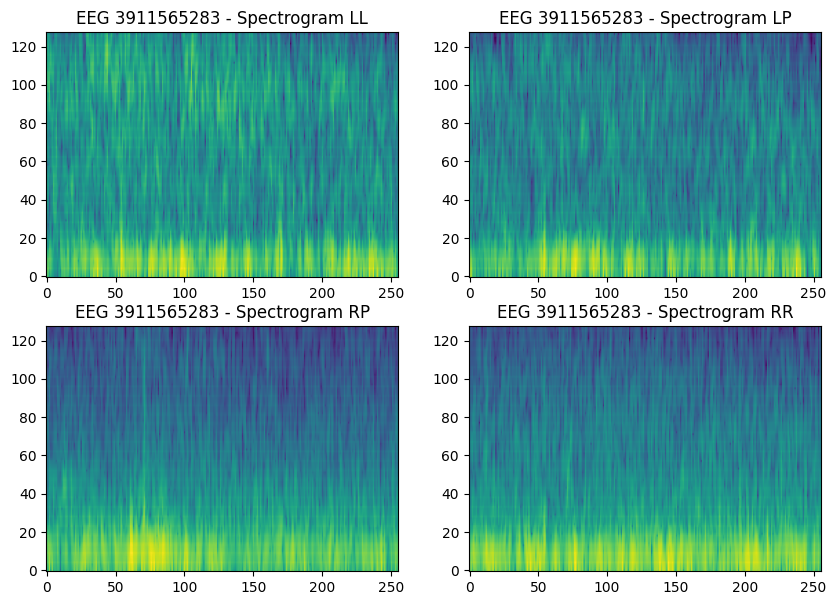

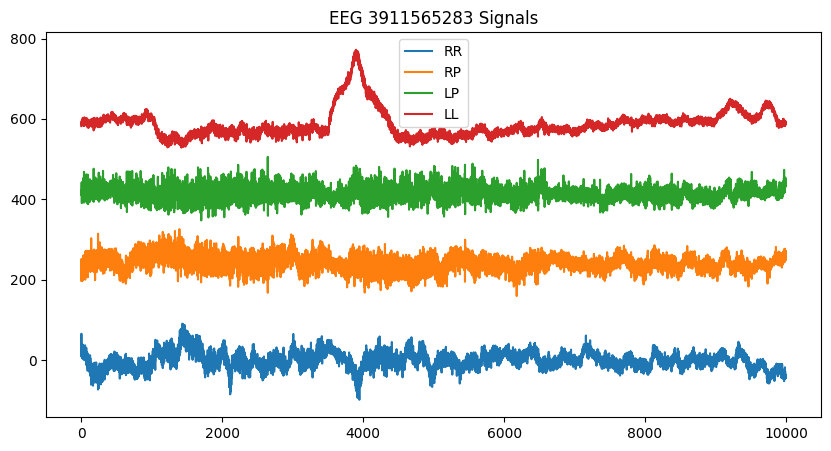

100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


#########################

CPU times: user 2.55 s, sys: 1.18 s, total: 3.73 s
Wall time: 1.79 s


In [13]:
%%time

paths_eegs = glob(paths.TEST_EEGS + "*.parquet")
print(f'There are {len(paths_eegs)} EEG spectrograms')
all_eegs = {}
counter = 0

for file_path in tqdm(paths_eegs):
    eeg_id = file_path.split("/")[-1].split(".")[0]
    eeg_spectrogram = spectrogram_from_eeg(file_path, counter < 1)
    all_eegs[int(eeg_id)] = eeg_spectrogram
    counter += 1

## Normalise


In [14]:
if config.NORMALIZE_EEG_SPECS:
    print("Normalizing eeg spectrograms")

    with open(paths.DATA_STATS_EEG) as info_file:
        info = json.load(info_file)
    mean = float(info["mean"])
    std = float(info["std"])
    print(f"mean: {mean}")
    print(f"std: {std}")

    for eeg_id in list(all_eegs.keys()):
        all_eegs[eeg_id] = (all_eegs[eeg_id] - mean) / std

Normalizing eeg spectrograms
mean: 0.25156814
std: 0.23112082


In [15]:
if config.NORMALIZE_KAGGLE_SPECS:
    print("Normalizing kaggle spectrograms")

    with open(paths.DATA_STATS_KAGGLE) as info_file:
        info = json.load(info_file)
    mean = float(info["mean"])
    std = float(info["std"])
    print(f"mean: {mean}")
    print(f"std: {std}")

    for spec_id in list(all_spectrograms.keys()):
        all_spectrograms[spec_id] = (all_spectrograms[spec_id] - mean) / std

Normalizing kaggle spectrograms
mean: 4884.119
std: 48154.293


# <b><span style='color:#F1A424'>|</span> Dataset</b><a class='anchor' id='dataset'></a> [↑](#top)

---

Create a custom `Dataset` to load data.

This dataloader outputs 4 spectrogram images as a 4 channel image of size 128x256x4 per train sample. This notebook version is not using data augmention but the code is available below to experiment with `albumentations` data augmention. Just add `augment = True` when creating the train data loader. And consider adding new transformations to the augment function below.

A more detailed [explanation][1] of the `r` parameter inside the `__data_generation()` method.

Our dataloader outputs both Kaggle spectrograms and EEG spectrogams as 8 channel image of size `(128, 256, 8)`

[1]: https://www.kaggle.com/code/cdeotte/efficientnetb0-starter-lb-0-43/comments#2617811


In [16]:
class CustomDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        config,
        augment: bool = False,
        mode: str = "train",
        specs: Dict[int, np.ndarray] = all_spectrograms,
        eeg_specs: Dict[int, np.ndarray] = all_eegs,
    ):
        self.df = df
        self.config = config
        self.batch_size = self.config.BATCH_SIZE
        self.augment = augment
        self.mode = mode
        self.spectrograms = all_spectrograms
        self.eeg_spectrograms = all_eegs

    def __len__(self):
        """
        Denotes the number of batches per epoch.
        """
        return len(self.df)

    def __getitem__(self, index):
        """
        Generate one batch of data.
        """
        X, y = self.__data_generation(index)
        if self.augment:
            X = self.__transform(X)
        return torch.tensor(X, dtype=torch.float32), torch.tensor(
            y, dtype=torch.float32
        )

    def __data_generation(self, index):
        """
        Generates data containing batch_size samples.
        """
        X = np.zeros((128, 256, 8), dtype="float32")
        y = np.zeros(6, dtype="float32")
        img = np.ones((128, 256), dtype="float32")
        row = self.df.iloc[index]
        if self.mode == "test":
            r = 0
        else:
            r = int((row["min"] + row["max"]) // 4)

        for region in range(4):
            img = self.spectrograms[row.spectrogram_id][
                r : r + 300, region * 100 : (region + 1) * 100
            ].T

            # Log transform spectrogram
            img = np.clip(img, np.exp(-4), np.exp(8))
            img = np.log(img)

            # Standarize per image
            ep = 1e-6
            mu = np.nanmean(img.flatten())
            std = np.nanstd(img.flatten())
            img = (img - mu) / (std + ep)
            img = np.nan_to_num(img, nan=0.0)
            X[14:-14, :, region] = img[:, 22:-22] / 2.0
            img = self.eeg_spectrograms[row.eeg_id]
            X[:, :, 4:] = img

            if self.mode != "test":
                y = row[label_cols].values.astype(np.float32)

        return X, y

    def __transform(self, img):
        transforms = A.Compose(
            [
                A.HorizontalFlip(p=0.5),
            ]
        )
        return transforms(image=img)["image"]

# <b><span style='color:#F1A424'>|</span> DataLoader</b><a class='anchor' id='dataloader'></a> [↑](#top)

---

Below we display example dataloader spectrogram images.


In [17]:
test_dataset = CustomDataset(test_df, config, mode="test")
test_loader = DataLoader(
    test_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=config.NUM_WORKERS,
    pin_memory=True,
    drop_last=False,
)
X, y = test_dataset[0]
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: torch.Size([128, 256, 8])
y shape: torch.Size([6])


# <b><span style='color:#F1A424'>|</span> Model</b><a class='anchor' id='model'></a> [↑](#top)

---

We will be using the [timm](https://github.com/huggingface/pytorch-image-models) library for our models.

Our models receives both Kaggle spectrograms and EEG spectrograms from our data loader. We then reshape these 8 spectrograms into 1 large flat image and feed it into EfficientNet.


In [18]:
from distutils.dir_util import copy_tree


copy_tree(
    "/kaggle/input/zipped-torchvision-hub",
    "/root/.cache/torch/hub/pytorch_vision_v0.10.0",
)
# print(os.listdir('/root/.cache/torch/hub/pytorch_vision_v0.10.0'))


class CustomModel(nn.Module):
    def __init__(self, config, num_classes: int = 6):
        super(CustomModel, self).__init__()
        self.USE_KAGGLE_SPECTROGRAMS = True
        self.USE_EEG_SPECTROGRAMS = True
        self.config = config
        self.num_classes = 6
        self.model = (
            timm.create_model(
                config.MODEL,
                pretrained=False,
                drop_rate=0.1,
                drop_path_rate=0.2,
            )
            if config.MODEL.startswith("tf_")
            else torch.hub.load(
                "pytorch/vision:v0.10.0", config.MODEL, pretrained=False
            )
        )

        self.features = self.set_feature_layers()
        self.custom_layers = self.set_custom_layers()

    def set_custom_layers(self):
        # this should probs become a dict once we know which sizes we are going to use
        if self.config.MODEL.startswith("tf_"):
            print("lrhbsdf")
            num_features = self.model.num_features
        elif self.config.MODEL.startswith("shufflenet"):
            num_features = 1024  # need to make this better
        elif self.config.MODEL.startswith("resnet"):
            num_features = 2048
        else:
            raise NotImplementedError("Model not implemented - check model name.")

        if getattr(
            self.config, "LARGE_CLASSIFIER", False
        ):  # not all will have attribute so to not break it return False if attr does not exist
            return nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Flatten(),
                nn.Linear(num_features, 256),
                nn.BatchNorm1d(
                    256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
                ),
                nn.ReLU(inplace=True),
                nn.Linear(256, self.num_classes),
            )

        else:
            return nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Flatten(),
                nn.Linear(num_features, self.num_classes),
            )

    def set_feature_layers(self):
        if self.config.MODEL.startswith("tf_") or self.config.MODEL.startswith(
            "resnet"
        ):
            return nn.Sequential(*list(self.model.children())[:-2])

        elif self.config.MODEL.startswith("shufflenet"):
            return nn.Sequential(*list(self.model.children())[:-1])

    def __reshape_input(self, x):
        """
        Reshapes input (128, 256, 8) -> (512, 512, 3) monotone image.
        """
        # === Get spectrograms ===
        spectrograms = [x[:, :, :, i : i + 1] for i in range(4)]
        spectrograms = torch.cat(spectrograms, dim=1)

        # === Get EEG spectrograms ===
        eegs = [x[:, :, :, i : i + 1] for i in range(4, 8)]
        eegs = torch.cat(eegs, dim=1)

        # === Reshape (512,512,3) ===
        if self.USE_KAGGLE_SPECTROGRAMS & self.USE_EEG_SPECTROGRAMS:
            x = torch.cat([spectrograms, eegs], dim=2)
        elif self.USE_EEG_SPECTROGRAMS:
            x = eegs
        else:
            x = spectrograms

        x = torch.cat([x, x, x], dim=3)
        x = x.permute(0, 3, 1, 2)
        return x

    def forward(self, x):
        x = self.__reshape_input(x)
        x = self.features(x)
        x = self.custom_layers(x)
        return x

# <b><span style='color:#F1A424'>|</span> Inference Function</b><a class='anchor' id='inference_function'></a> [↑](#top)

---


In [19]:
def inference_function(test_loader, model, device):
    model.eval()
    softmax = nn.Softmax(dim=1)
    prediction_dict = {}
    preds = []
    with tqdm(test_loader, unit="test_batch", desc="Inference") as tqdm_test_loader:
        for step, (X, y) in enumerate(tqdm_test_loader):
            X = X.to(device)
            y = y.to(device)
            batch_size = y.size(0)
            with torch.no_grad():
                y_preds = model(X)
            y_preds = softmax(y_preds)
            preds.append(y_preds.to("cpu").numpy())

    prediction_dict["predictions"] = np.concatenate(preds)
    return prediction_dict

# <b><span style='color:#F1A424'>|</span> Infer</b><a class='anchor' id='infer'></a> [↑](#top)

---


In [20]:
predictions = []

for cur_config, model_weight in model_weights:
    print(model_weight)
    test_dataset = CustomDataset(test_df, cur_config, mode="test", augment=False)
    train_loader = DataLoader(
        test_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=config.NUM_WORKERS,
        pin_memory=True,
        drop_last=False,
    )
    model = CustomModel(cur_config)
    checkpoint = torch.load(model_weight)
    if len(checkpoint) == 2:
        model.load_state_dict(checkpoint["model"])
    else:
        model.load_state_dict(checkpoint)
    model.to(device)
    prediction_dict = inference_function(test_loader, model, device)
    predictions.append(prediction_dict["predictions"])
    torch.cuda.empty_cache()
    gc.collect()

predictions = np.array(predictions)
predictions = np.mean(predictions, axis=0)

/kaggle/input/b0-first-run/tf_efficientnet_b0_fold_4_best_False_best_prepr.pth
lrhbsdf


Inference: 100%|██████████| 1/1 [00:00<00:00,  1.23test_batch/s]


# <b><span style='color:#F1A424'>|</span> Save Submission</b><a class='anchor' id='submission'></a> [↑](#top)

---


In [21]:
TARGETS = [
    "seizure_vote",
    "lpd_vote",
    "gpd_vote",
    "lrda_vote",
    "grda_vote",
    "other_vote",
]
sub = pd.DataFrame({"eeg_id": test_df.eeg_id.values})
sub[TARGETS] = predictions
sub.to_csv("submission.csv", index=False)
print(f"Submissionn shape: {sub.shape}")
sub.head()

Submissionn shape: (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.005555,0.066306,0.001303,0.31147,0.057718,0.557647
